In [33]:
import gc
import numpy as np
import pandas as pd
import yfinance as yf
import back_testing as bt
import matplotlib.pyplot as plt

gc.collect()

10755

In [34]:
tickers = ["GC=F", "^GSPC", "LMT"]
data = yf.download(tickers, start="2000-01-01")

[*********************100%***********************]  3 of 3 completed


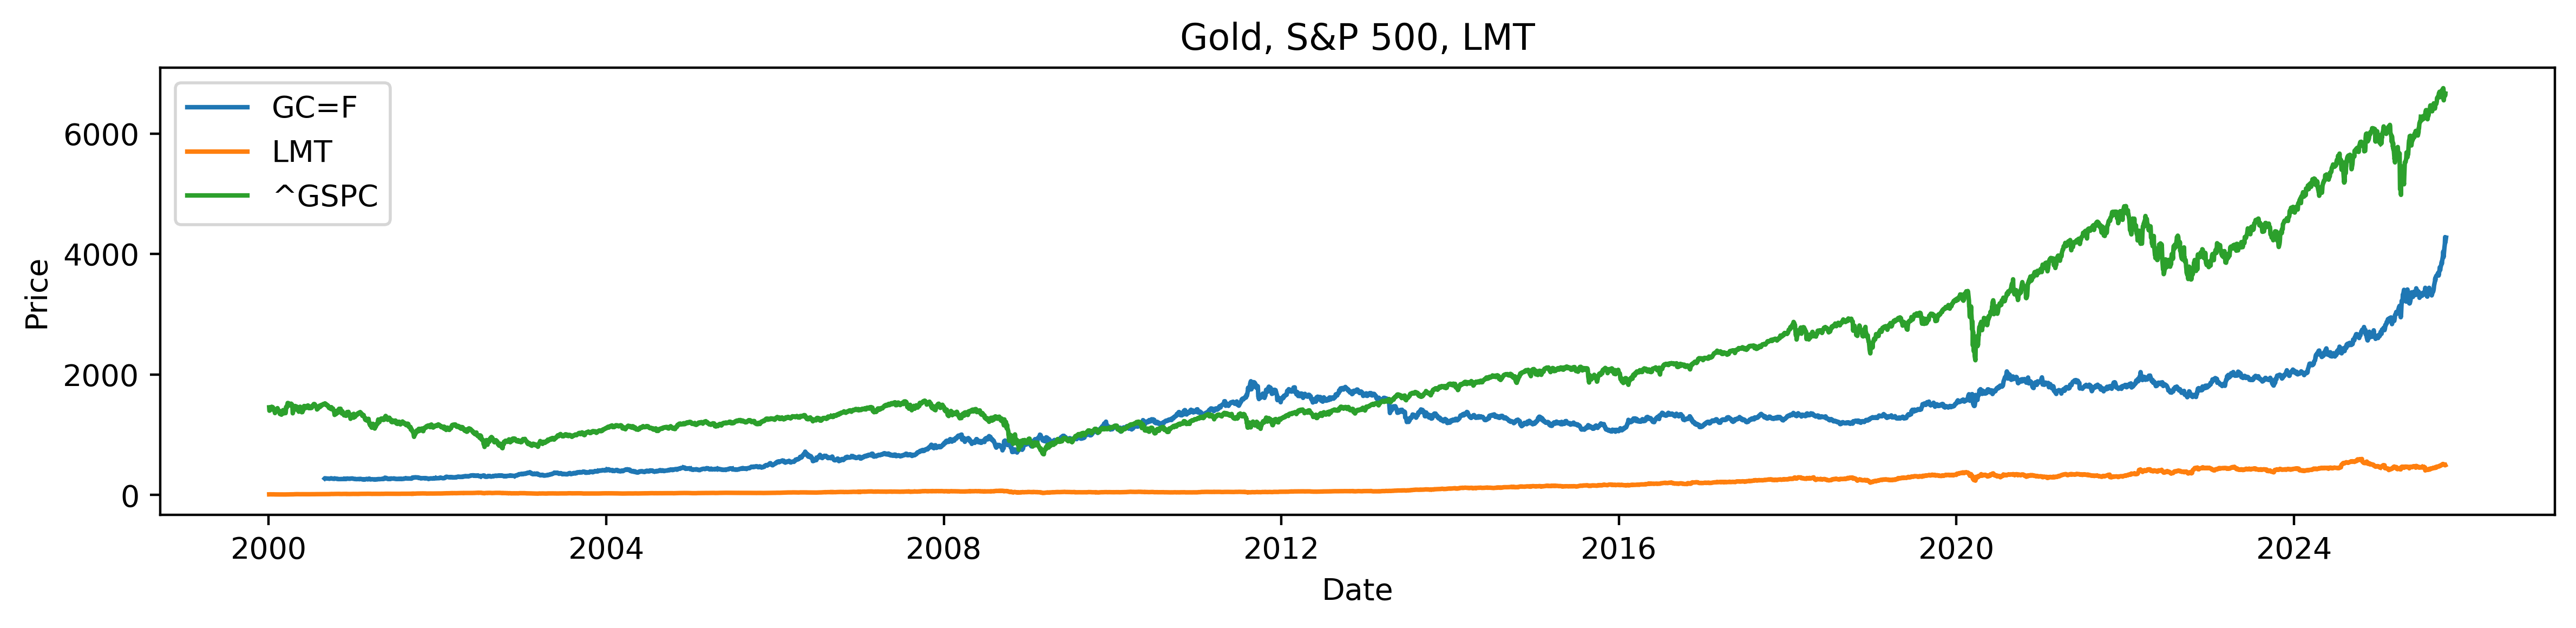

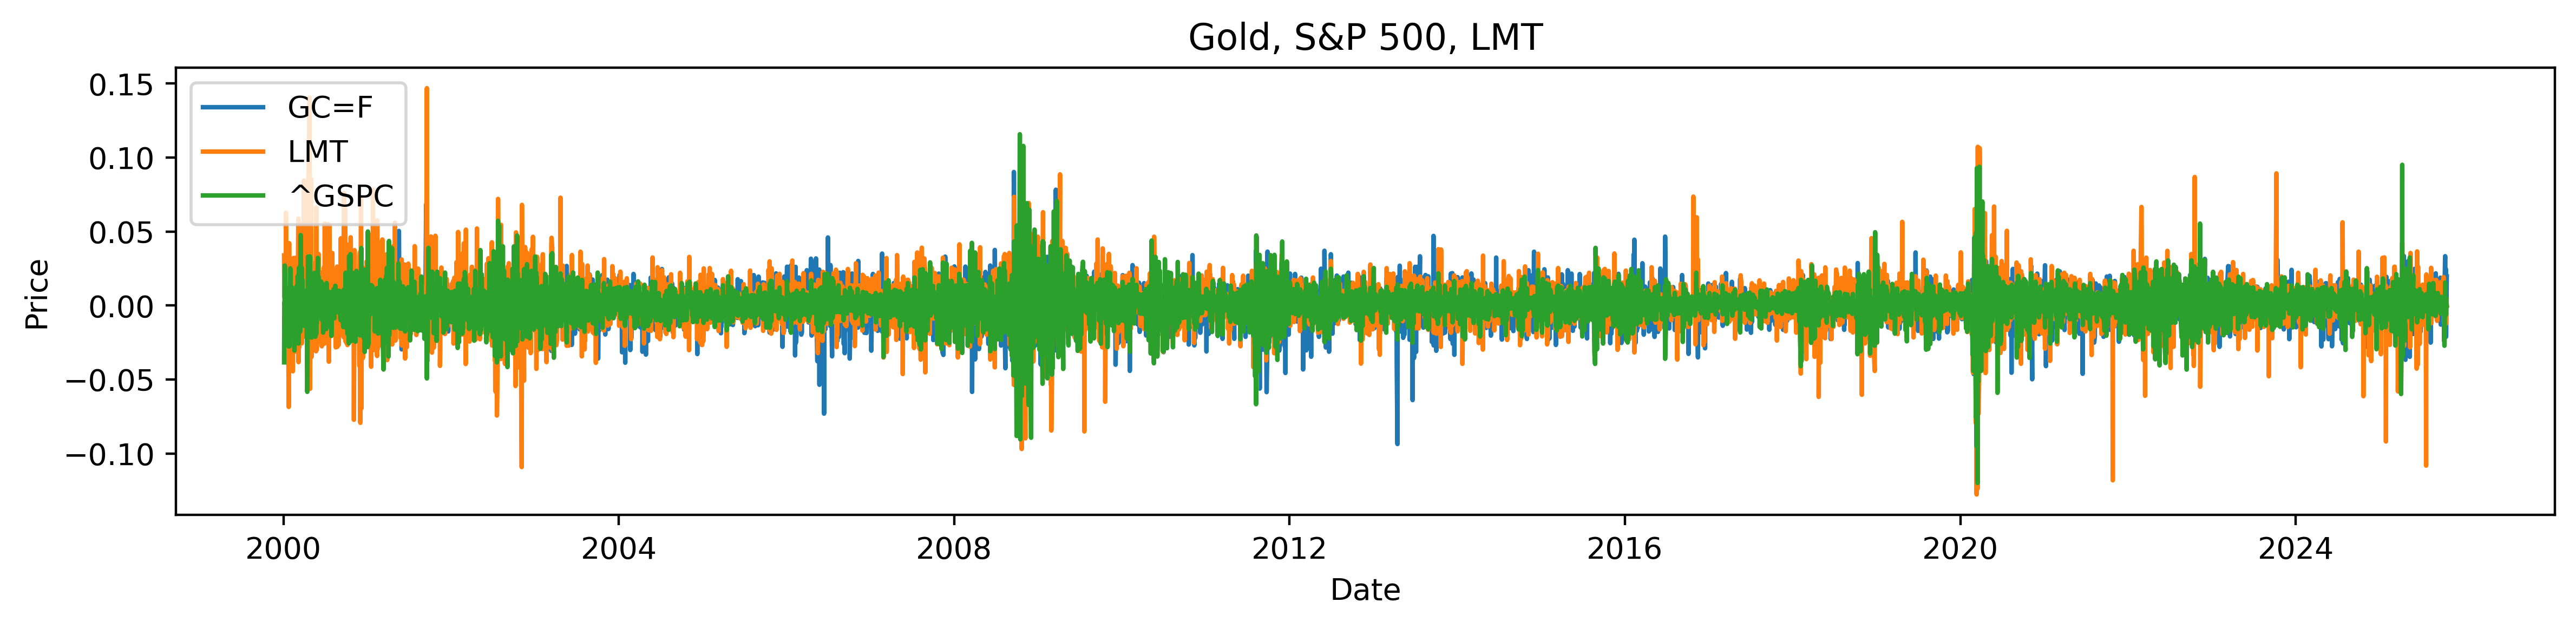

In [35]:
# 시각화
plt.figure(figsize=(12, 3), dpi=400)
plt.plot(data['Close'])
plt.title("Gold, S&P 500, LMT")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(data['Close'].columns, loc='upper left')
plt.tight_layout()
plt.show()

# 시각화
plt.figure(figsize=(12, 3), dpi=400)
plt.plot(data['Close'].pct_change())
plt.title("Gold, S&P 500, LMT")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(data['Close'].columns, loc='upper left')
plt.tight_layout()
plt.show()

In [36]:
# 각 투자 성향별 배분비율 (Gold, S&P500, LMT 순서)
allocation_ratios = {
    'Very_Conservative': [0.8, 0.15, 0.05],  # 매우 보수적: 금 80%, S&P500 15%, LMT 5%
    'Conservative': [0.4, 0.5, 0.1],         # 보수적: 금 40%, S&P500 50%, LMT 10%
    'Balanced': [0.25, 0.5, 0.25],           # 균형: 금 25%, S&P500 50%, LMT 25%
    'Aggressive': [0.1, 0.3, 0.6],           # 공격적: 금 10%, S&P500 30%, LMT 60%
    'Very_Aggressive': [0.05, 0.15, 0.8]     # 매우 공격적: 금 5%, S&P500 15%, LMT 80%
}

start_date = '2000-01-01'
end_date = '2025-06-30'
date_index = pd.date_range(start=start_date, end=end_date, freq='D')
col_order = list(data['Close'].columns)   # 예: ['Gold', 'S&P500', 'LMT']

# 1) 전략별 상수 가중치 테이블들 (weight_dict) — vectorized
weight_dict = {}
for strategy, ratios in allocation_ratios.items():
    arr = np.tile(np.asarray(ratios, dtype=float), (len(date_index), 1))
    strategy_df = pd.DataFrame(arr, index=date_index, columns=col_order)
    weight_dict[strategy] = strategy_df

In [37]:
# Calculate S&P 500 200-day moving average and market conditions
# Add VIX data for market volatility analysis
vix_data = yf.download("^VIX", start="2000-01-01")['Close']

sp500_data = data['Close']['^GSPC'].dropna()
sp500_ma200 = sp500_data.rolling(window=30).mean()

# Create market condition indicators
market_conditions = pd.DataFrame(index=sp500_data.index)
market_conditions['sp500_price'] = sp500_data
market_conditions['sp500_ma200'] = sp500_ma200
market_conditions['above_ma200'] = sp500_data > sp500_ma200
market_conditions['vix'] = vix_data.reindex(sp500_data.index, method='ffill')
market_conditions['vix_high'] = market_conditions['vix'] >= 20

# Create combined market condition
market_conditions['market_regime'] = 'Balanced'  # Default
market_conditions.loc[
    (market_conditions['above_ma200'] == True) & (market_conditions['vix_high'] == False), 
    'market_regime'
] = 'Very_Aggressive'
market_conditions.loc[
    (market_conditions['above_ma200'] == False) & (market_conditions['vix_high'] == True), 
    'market_regime'
] = 'Very_Conservative'

regimes = (
    market_conditions
    .reindex(date_index)[ 'market_regime' ]
    .ffill()
)

#   - 레짐 -> 리스트 매핑 (모르면 Balanced로 대체)
regime_weights_list = regimes.map(
    lambda r: allocation_ratios.get(r, allocation_ratios['Balanced'])
).to_list()

dynamic_weights = pd.DataFrame(regime_weights_list, index=date_index, columns=col_order)

weight_dict['Dynamic'] = dynamic_weights

[*********************100%***********************]  1 of 1 completed


설정:
  - 기본 수수료: 0.02%
  - Turnover 배수: 1
  - 리밸런싱 주기: W


[*********************100%***********************]  1 of 1 completed


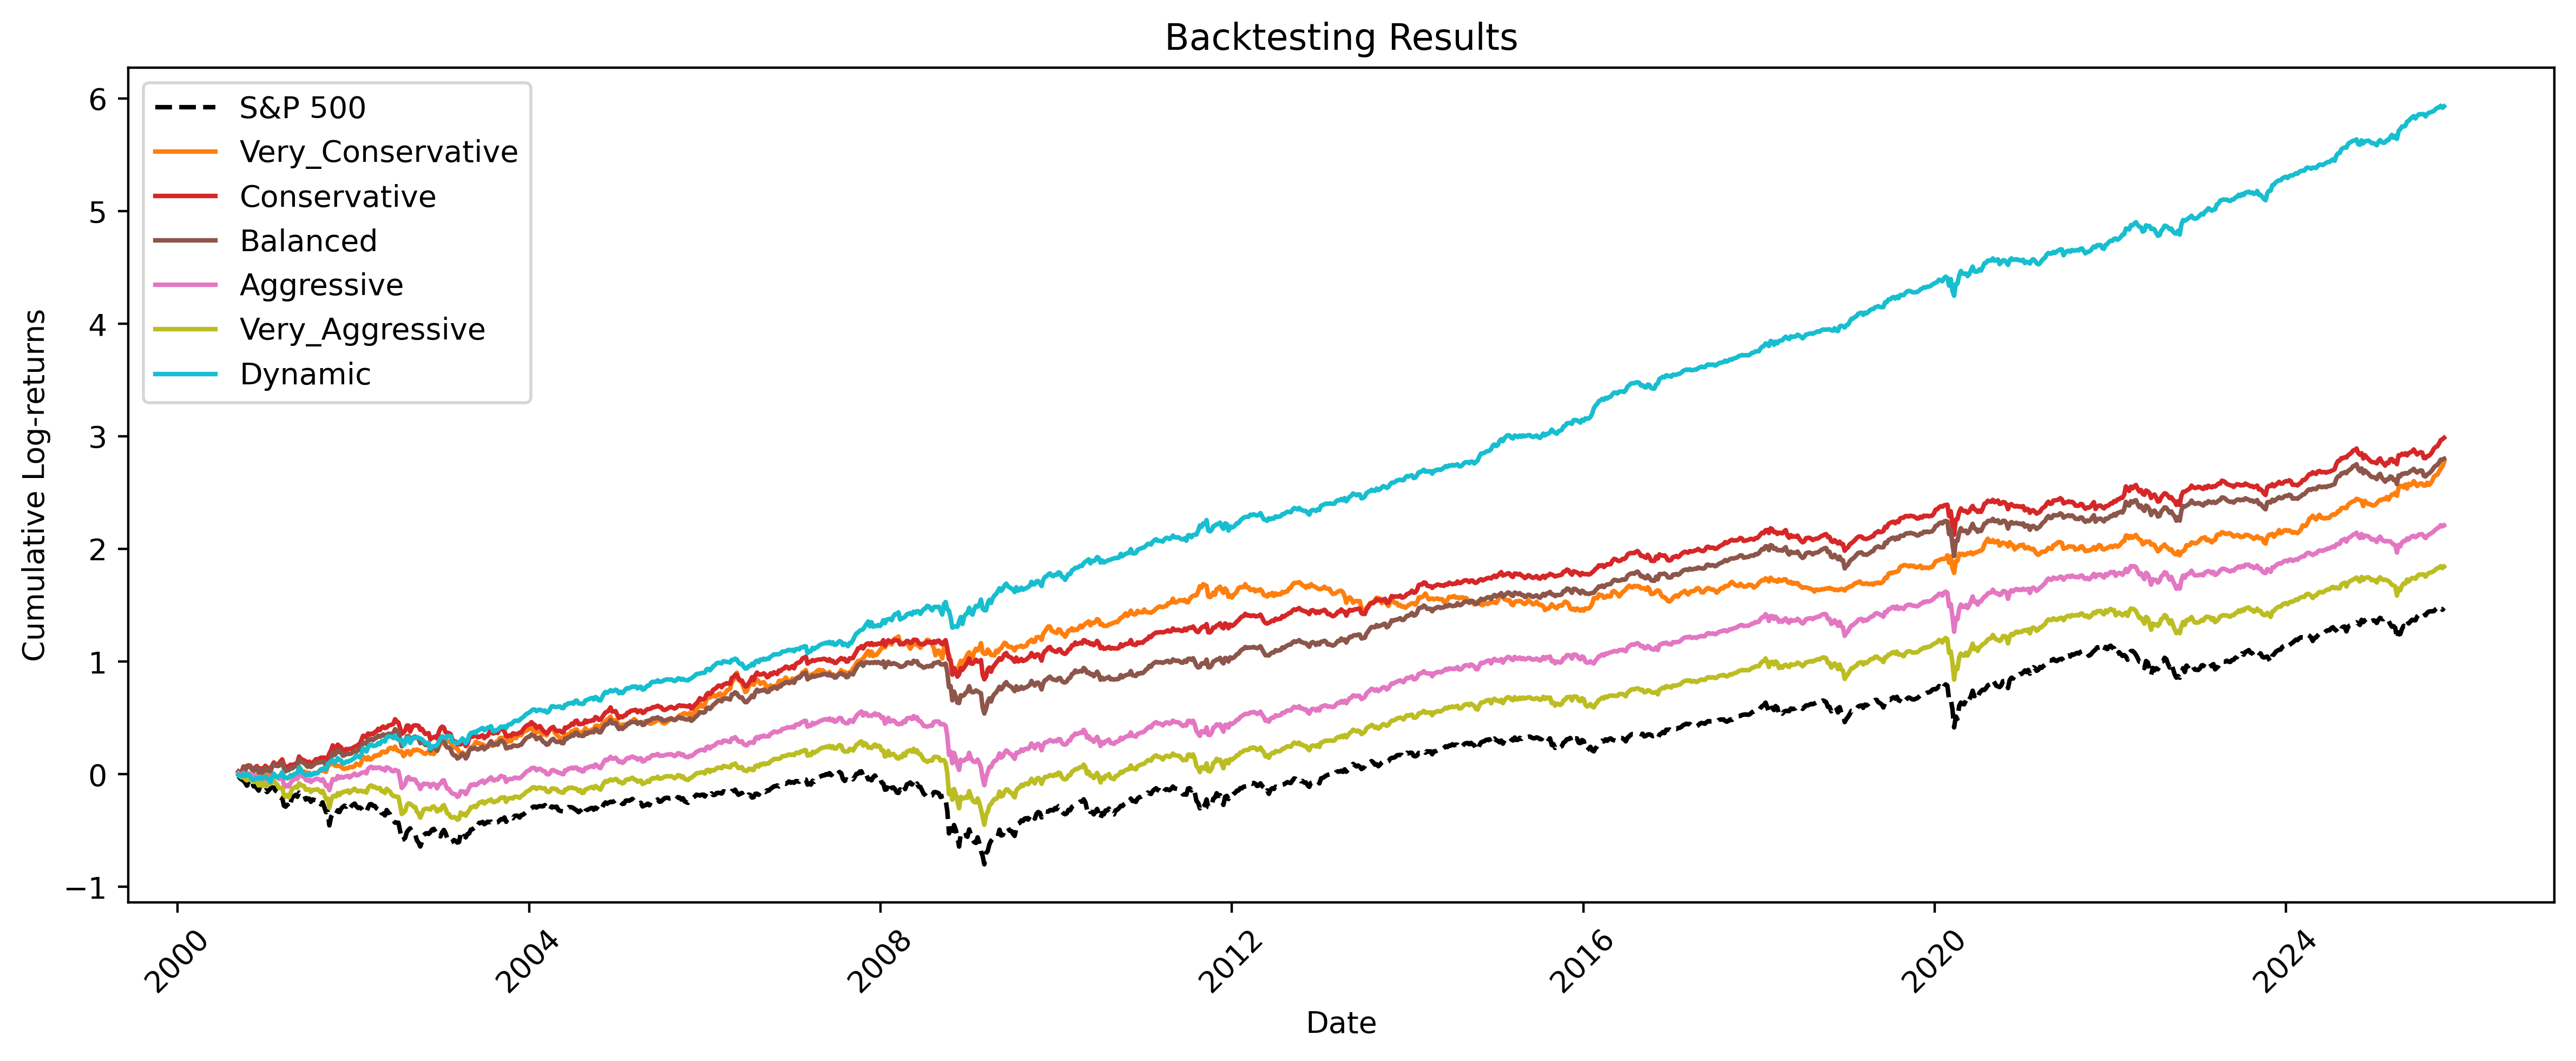

In [38]:
# 백테스팅 설정
base_fee = 0.0002  # 기본 수수료 0.02%
turnover_multiplier = 1  # turnover에 따른 수수료 증가 배수
rebalance_freq = 'W'  # 리밸런싱 주기: 'D', 'W', 'M', 'Q', 'Y'

print(f"설정:")
print(f"  - 기본 수수료: {base_fee*100:.2f}%")
print(f"  - Turnover 배수: {turnover_multiplier}")
print(f"  - 리밸런싱 주기: {rebalance_freq}")

# 백테스팅 실행
result_df = pd.DataFrame()
for str_name in weight_dict.keys():
    result_df = bt.return_Table(
        weight_dict[str_name], 
        data['Close'],  # 가격 데이터 직접 전달
        result_df,
        rebalance_freq=rebalance_freq,
        fee=base_fee,
        turnover_multiplier=turnover_multiplier
    )
    
# 컬럼명 설정 (S&P 500 + 전략들)
result_df.columns = ['S&P 500'] + list(weight_dict.keys())

bt.plot_result(result_df)

In [39]:
for freq in ['D', 'W', 'M', 'Q', 'Y']:  
    # turnover 계산 (예: 월별 리밸런스)
    turnover_per_period = bt.cal_turnover(weight_dict['Dynamic'], rebalance_freq=freq)

    # 수수료 효과 계산
    fee_log = bt.cal_dynamic_fee(turnover_per_period, fee=0.0002, turnover_multiplier=1)

    # 총 수수료 (log-return 기준 합산)
    total_fee = fee_log.sum()
    print(f"{freq} turnover_mean: {turnover_per_period.mean():.4f}")
    print(f"{freq} 총 수수료 (log return 합): {total_fee:.4f}")


D turnover_mean: 0.0523
D 총 수수료 (log return 합): -0.2697
W turnover_mean: 0.1559
W 총 수수료 (log return 합): -0.1127
M turnover_mean: 0.3087
M 총 수수료 (log return 합): -0.0507
Q turnover_mean: 0.3490
Q 총 수수료 (log return 합): -0.0191
Y turnover_mean: 0.4404
Y 총 수수료 (log return 합): -0.0061


In [40]:
metric = bt.METRICS(result_df.dropna())
metric.cal_describe()
metric.cal_monthly_statistics()

In [41]:
metric.annual_statistics

S&P 500  \
Date                            2000-09-10 ~ 2025-10-19   
count                                              1311   
cumulative return                             338.19971   
annualized return mean                          0.06036   
annualized return std                            0.1938   
annualized return downside std                  0.15683   
sharpe ratio                                    0.31143   
sortino ratio                                   0.38485   
gross profit                                   12.03209   
gross loss                                    -10.55459   
profit factor                                   1.13999   
maximum drawdown                               -0.56244   
calmar ratio                                    0.10731   
profitable years                                     19   
unprofitable years                                    7   
t-statistic                                         0.0   
p_value                                             1.0   

                                      Very_Conservative  \
Date                            2000-09-10 ~ 2025-10-19   
count                                              1311   
cumulative return                            1500.97565   
annualized return mean                          0.11627   
annualized return std                            0.1563   
annualized return downside std                  0.11113   
sharpe ratio                                    0.74392   
sortino ratio                                    1.0463   
gross profit                                    11.3061   
gross loss                                      -8.5329   
profit factor                                     1.325   
maximum drawdown                               -0.26781   
calmar ratio                                    0.43418   
profitable years                                     21   
unprofitable years                                    5   
t-statistic                                     8.13211   
p_value                                             0.0   

                                           Conservative  \
Date                            2000-09-10 ~ 2025-10-19   
count                                              1311   
cumulative return                            1885.16599   
annualized return mean                          0.12584   
annualized return std                           0.15854   
annualized return downside std                  0.12321   
sharpe ratio                                    0.79375   
sortino ratio                                   1.02135   
gross profit                                   11.22575   
gross loss                                     -8.23746   
profit factor                                   1.36277   
maximum drawdown                               -0.29675   
calmar ratio                                    0.42406   
profitable years                                     24   
unprofitable years                                    2   
t-statistic                                     9.46936   
p_value                                             0.0   

                                               Balanced  \
Date                            2000-09-10 ~ 2025-10-19   
count                                              1311   
cumulative return                             1548.5004   
annualized return mean                          0.11757   
annualized return std                           0.16272   
annualized return downside std                  0.13141   
sharpe ratio                                    0.72252   
sortino ratio                                   0.89469   
gross profit                                   11.13599   
gross loss                                     -8.33354   
profit factor                                   1.33629   
maximum drawdown                               -0.37452   
calmar ratio                                    0.31392   
profitable years                 

In [42]:
metric.monthly_statistics

S&P 500 Very_Conservative Conservative Balanced  \
Mean                0.00113           0.00212      0.00228  0.00214   
Standard deviation  0.02457           0.02014      0.02041  0.02091   
Standard error      0.00068           0.00056      0.00056  0.00058   
t-statistic          1.7558            4.0719        4.281   3.9268   
Min                -0.20084          -0.10532     -0.12973 -0.13366   
25%                -0.01031          -0.00868     -0.00785 -0.00792   
50%                 0.00253           0.00296      0.00354   0.0033   
75%                 0.01436           0.01399      0.01367  0.01347   
Max                 0.11424           0.10384      0.13541  0.13655   
Skew               -0.88696          -0.36334     -0.65408 -0.79851   
Kurtosis            7.41986           2.58185      6.33505  7.26603   

                   Aggressive Very_Aggressive  Dynamic  
Mean                  0.00169         0.00141  0.00453  
Standard deviation    0.02122         0.02235  0.01873  
Standard error        0.00059         0.00062  0.00052  
t-statistic            3.0657          2.4221  10.0974  
Min                  -0.17215        -0.18649 -0.10532  
25%                  -0.00796        -0.00837 -0.00518  
50%                   0.00318         0.00298  0.00471  
75%                   0.01277         0.01298  0.01467  
Max                   0.12139         0.10954  0.10384  
Skew                  -0.9676        -0.95562 -0.32232  
Kurtosis              8.42562         8.19491  4.14616

In [43]:
metric.save_results('./general_results')

In [44]:
tickers = ["RGTI", "IONQ", "NVDA", 'IBM', 'QBTS', 'QUBT']
data = yf.download(tickers, start="2000-01-01")

[*********************100%***********************]  6 of 6 completed


In [45]:
def plot_comn_improved(data, START_DATE, window=10):
    """
    개선된 주가 분석 함수
    - 가격, 수익률, 변동성을 정확하게 계산
    """
    df_price = data
    df_return = data.pct_change() * 100  # 백분율로 변환
    
    # 변동성 계산 (연간화된 변동성)
    df_vol = df_return.rolling(window=window).std() * np.sqrt(252)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), dpi=400)
    
    # 가격 차트
    ax1.plot(df_price[START_DATE:].index, df_price[START_DATE:],
            label=f'{data.name}', linewidth=1.5, color='blue')
    ax1.set_title(f'Price', fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 수익률 차트
    ax2.plot(df_return[START_DATE:].index, df_return[START_DATE:],
            label=f'{data.name} Return', linewidth=1.5, color='green')
    ax2.set_title(f'Daily Return', fontweight='bold')
    ax2.set_ylabel('Return (%)', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # 변동성 차트
    ax3.plot(df_vol[START_DATE:].index, df_vol[START_DATE:],
            label=f'{data.name} Volatility', linewidth=1.5, color='purple')
    ax3.set_title(f'Rolling Volatility ({window} days)', fontweight='bold')
    ax3.set_xlabel('Date', fontsize=12)
    ax3.set_ylabel('Volatility (%)', fontsize=12)
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 통계 정보 출력
    print(f"\n=== {data.name} 통계 정보 ===")
    print(f"평균 일일 수익률: {df_return[START_DATE:].mean():.4f}%")
    print(f"수익률 표준편차: {df_return[START_DATE:].std():.4f}%")
    print(f"평균 변동성: {df_vol[START_DATE:].mean():.4f}%")
    print(f"최대 변동성: {df_vol[START_DATE:].max():.4f}%")
    print(f"최소 변동성: {df_vol[START_DATE:].min():.4f}%")
    print(f"샤프 비율: {df_return[START_DATE:].mean()*100/df_vol[START_DATE:].mean():.4f}")
    
    gc.collect()


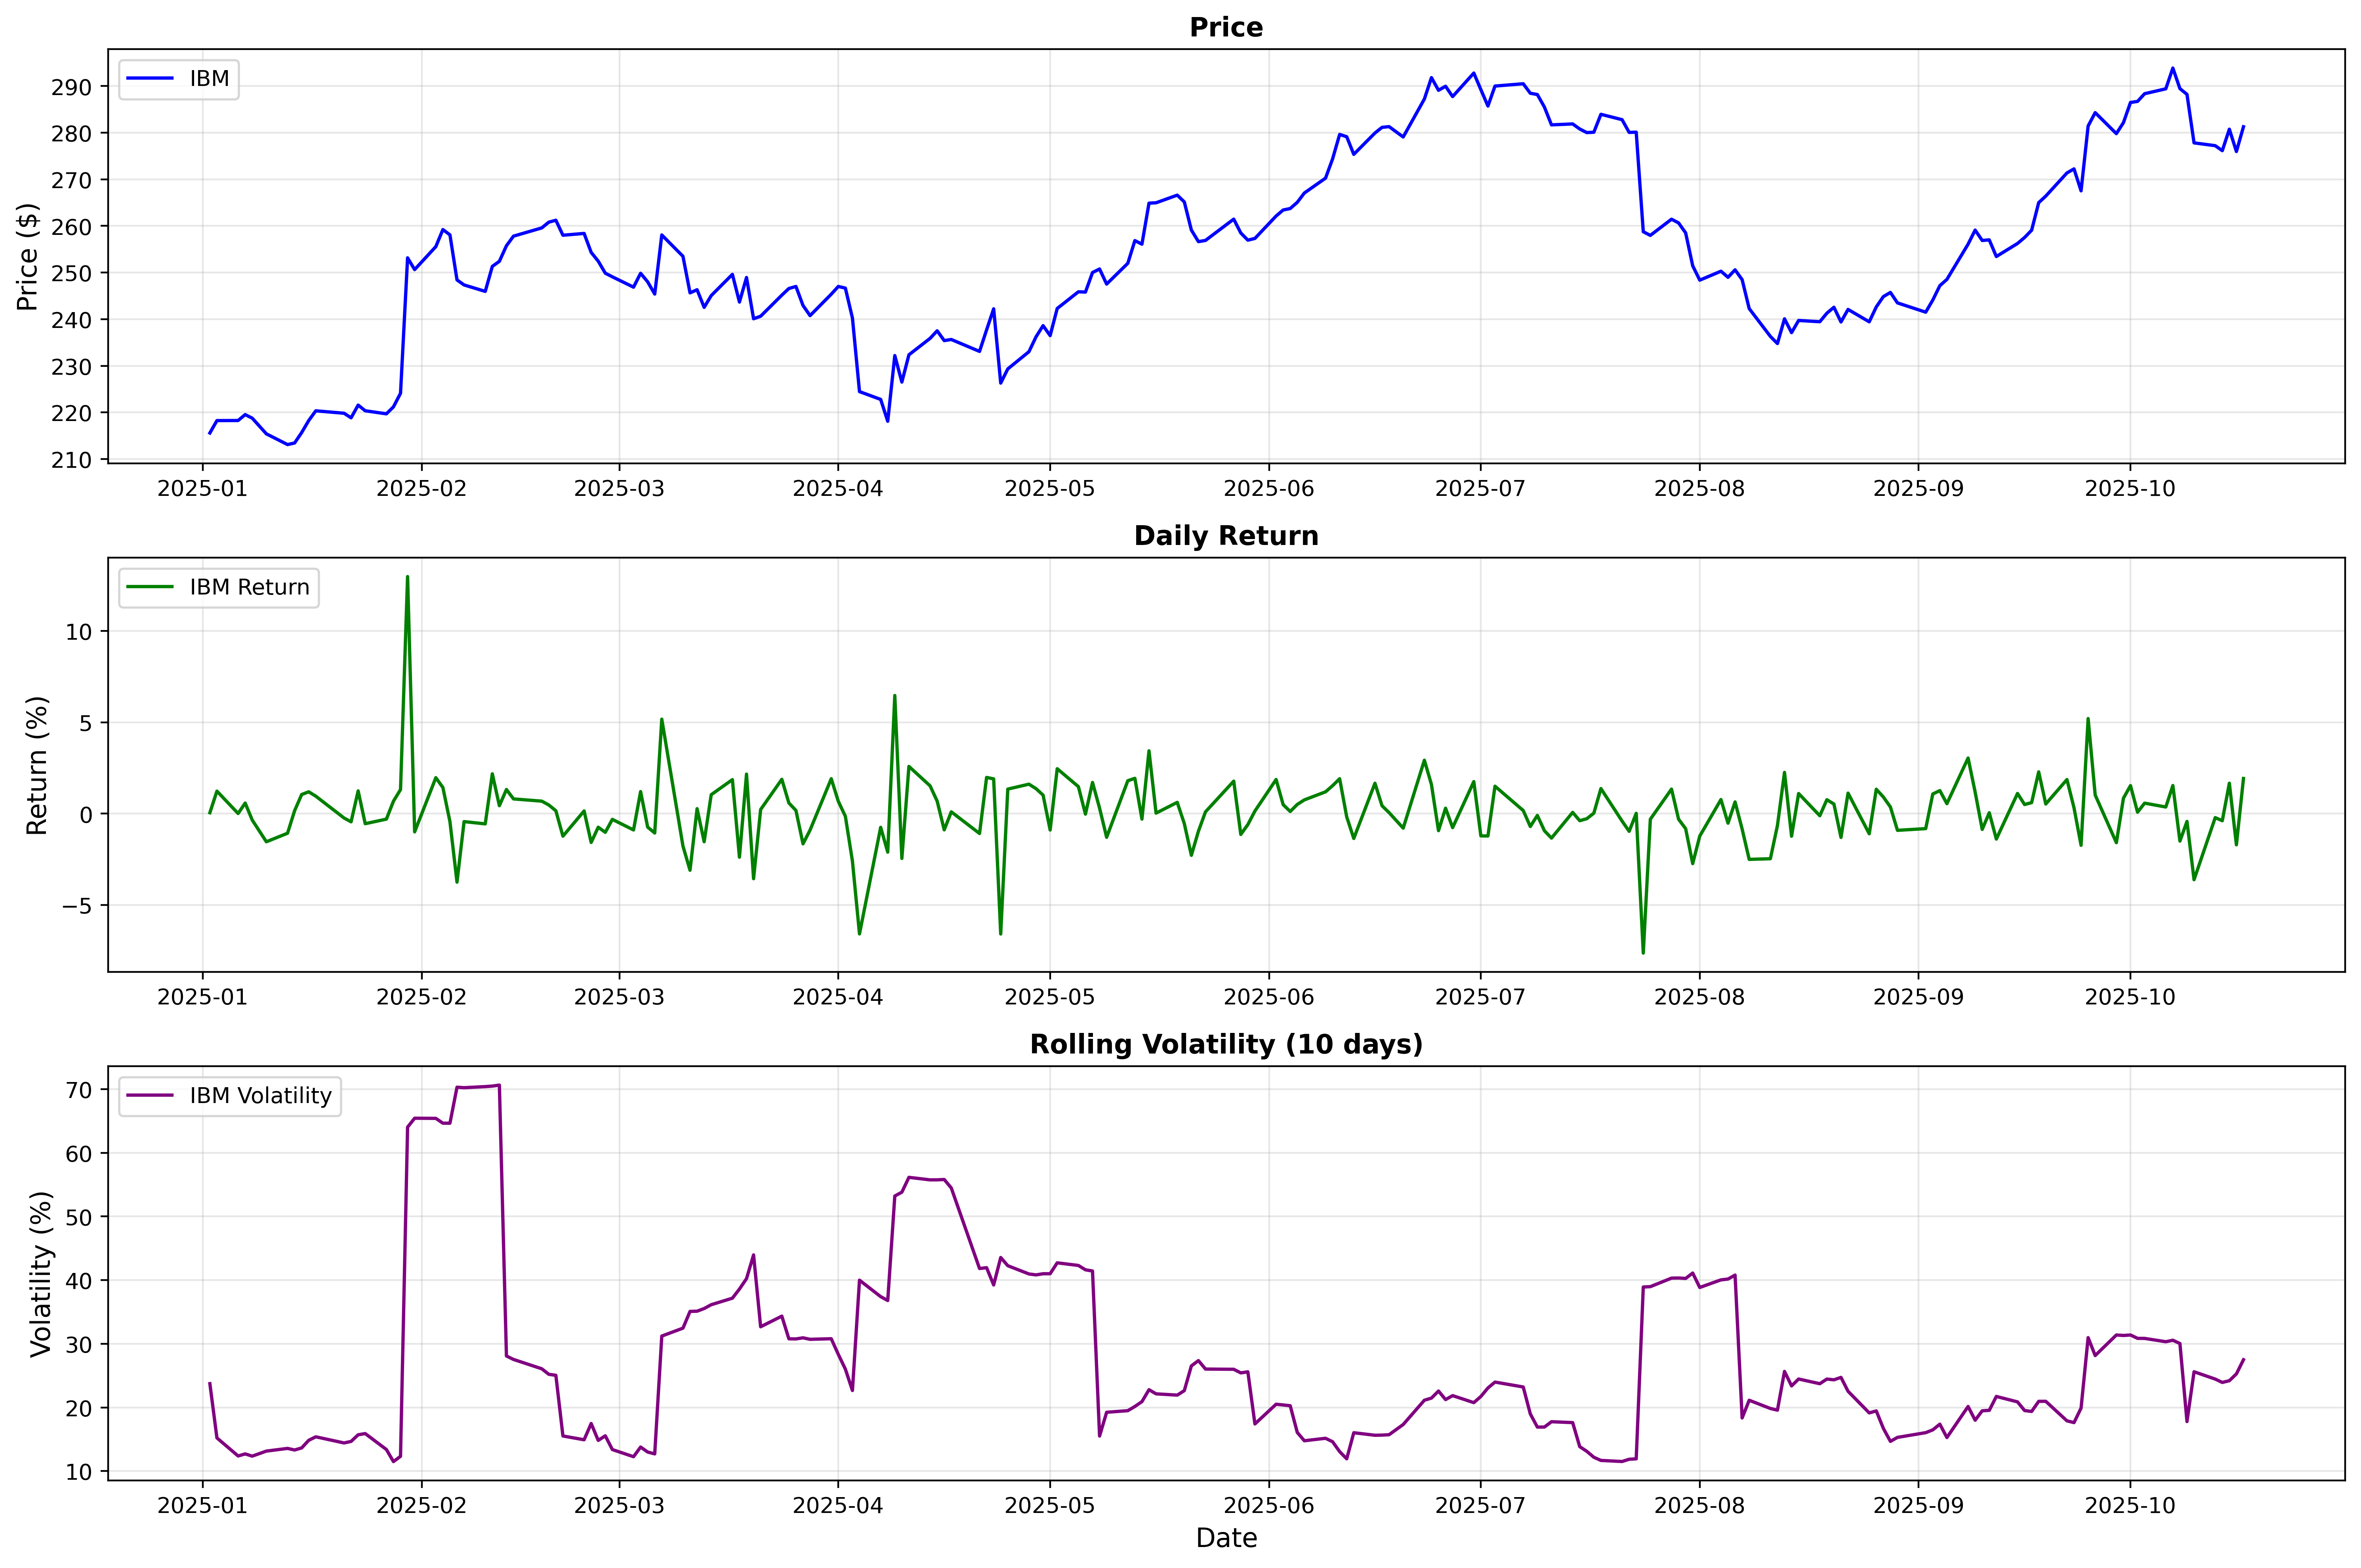


=== IBM 통계 정보 ===
평균 일일 수익률: 0.1527%
수익률 표준편차: 1.9483%
평균 변동성: 27.3734%
최대 변동성: 70.6431%
최소 변동성: 11.4880%
샤프 비율: 0.5578


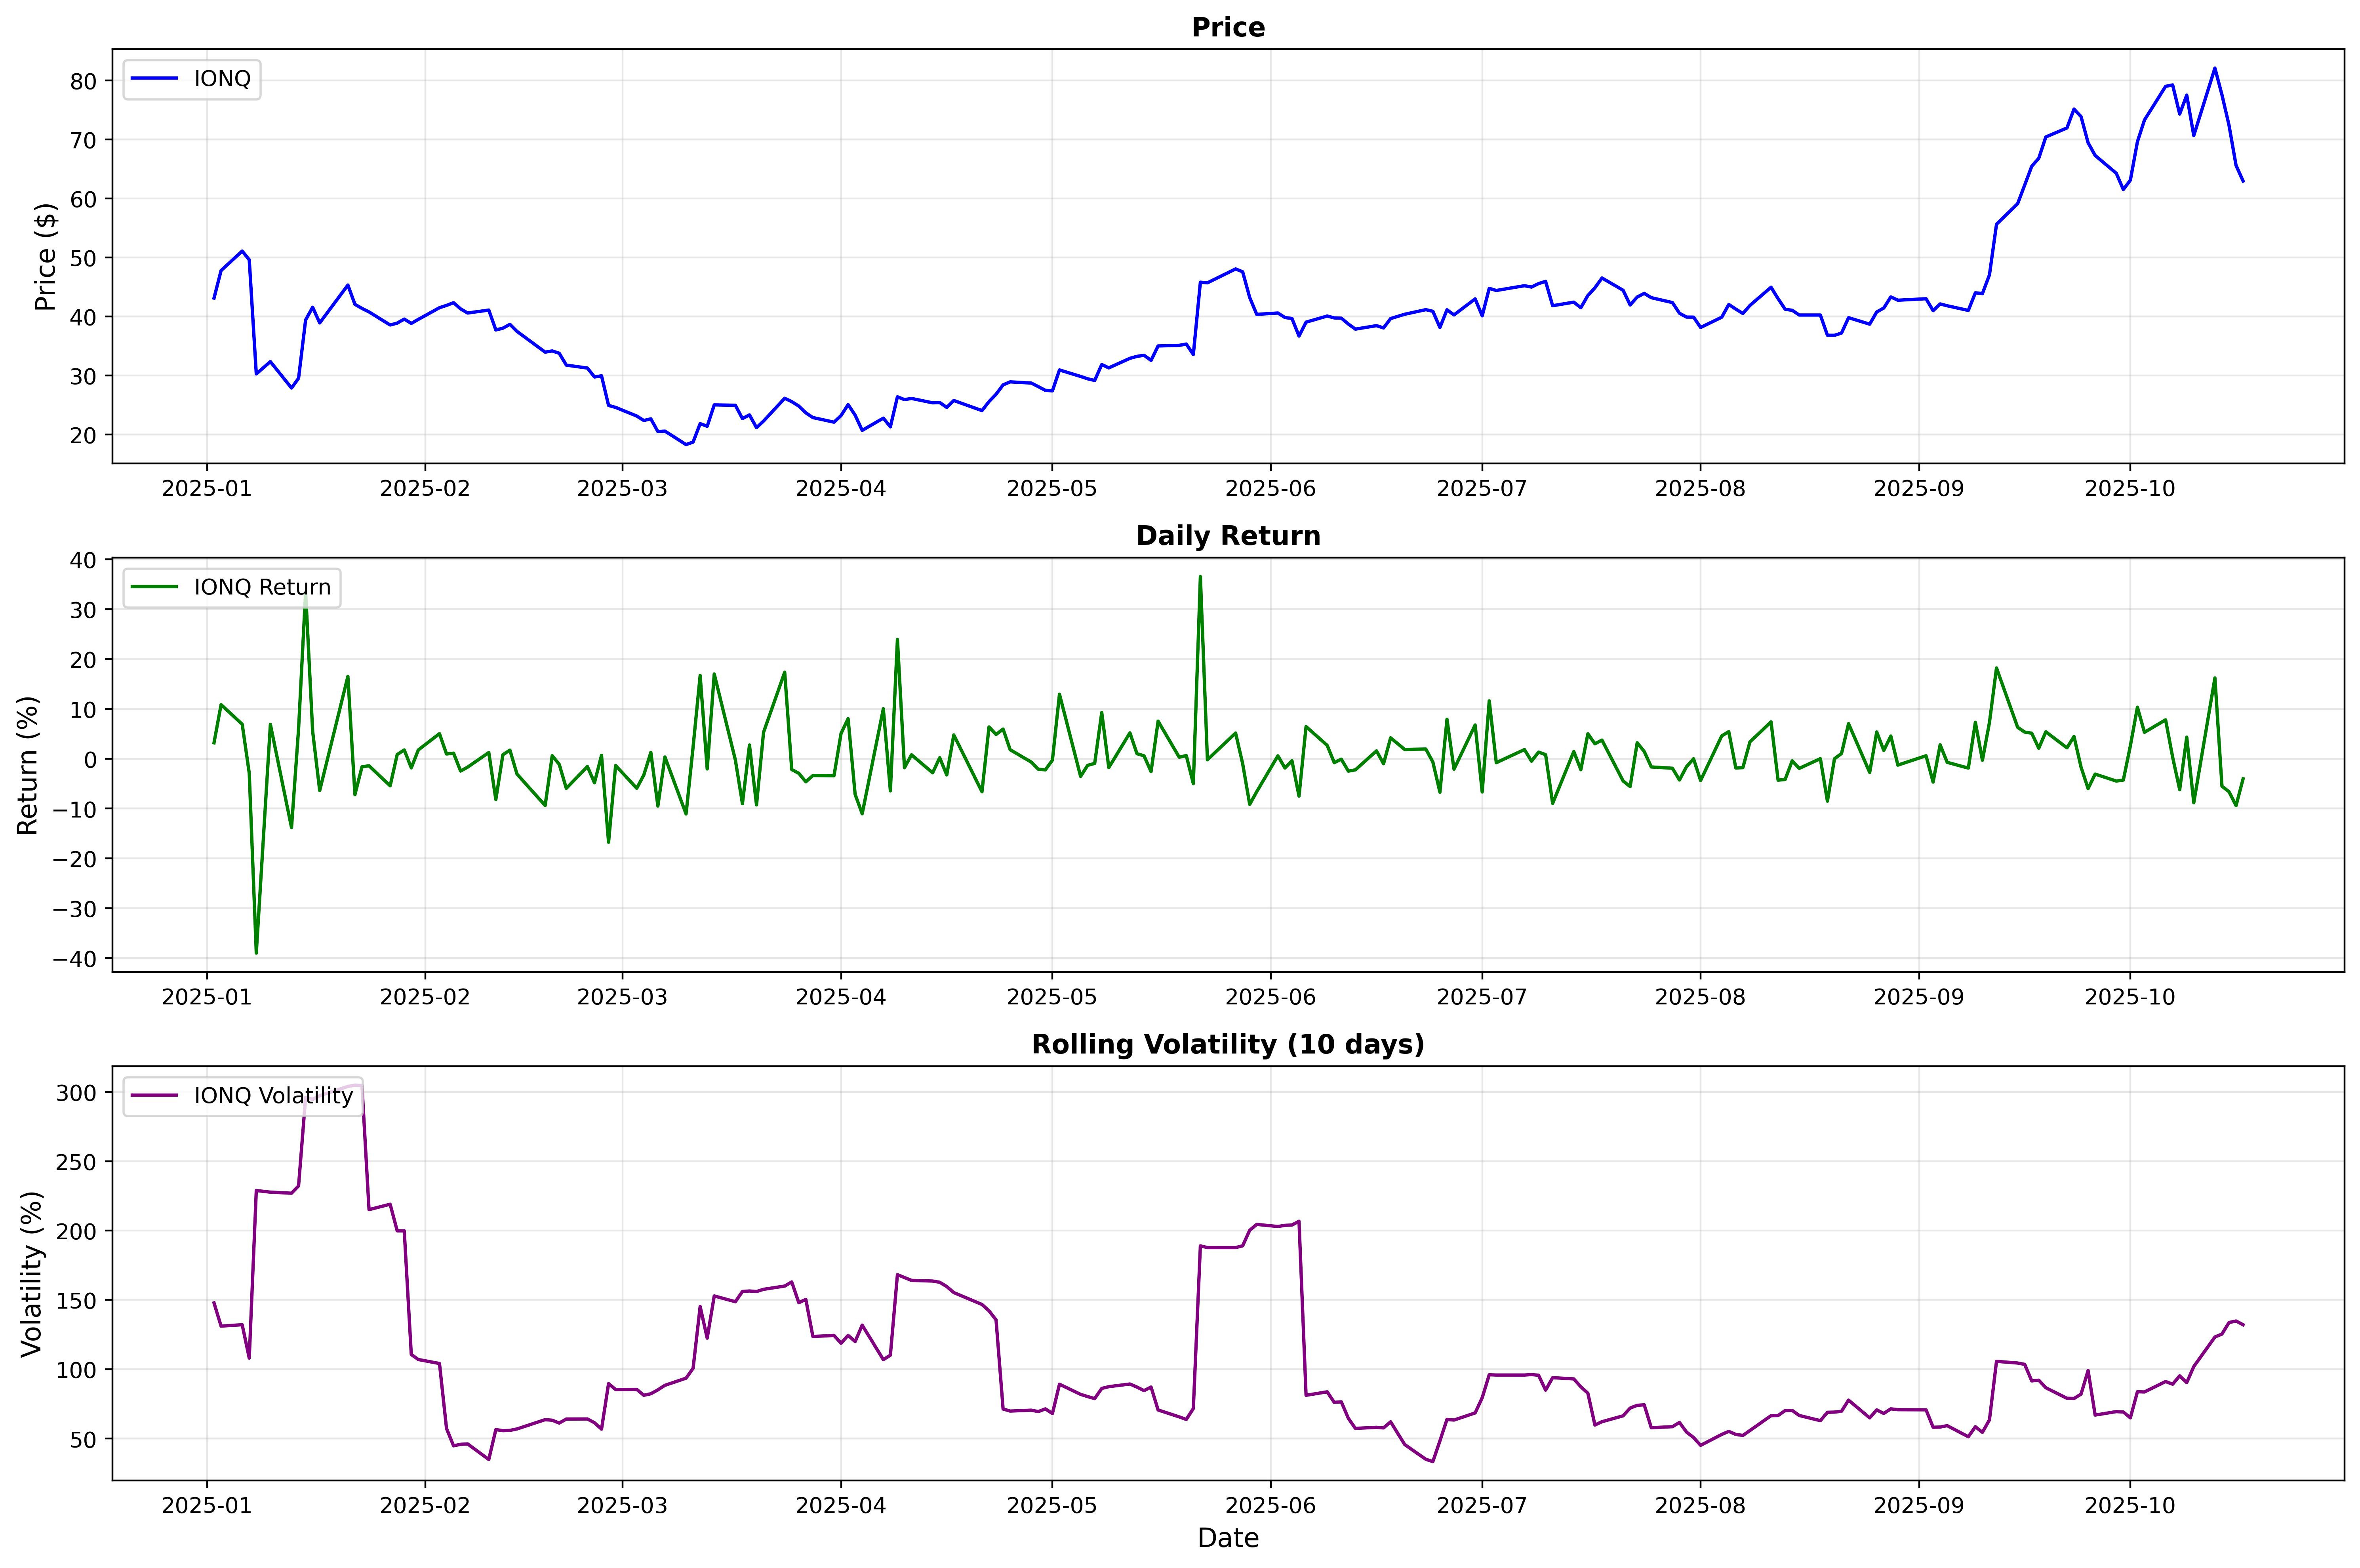


=== IONQ 통계 정보 ===
평균 일일 수익률: 0.4837%
수익률 표준편차: 7.4802%
평균 변동성: 105.0690%
최대 변동성: 304.8643%
최소 변동성: 33.4525%
샤프 비율: 0.4604


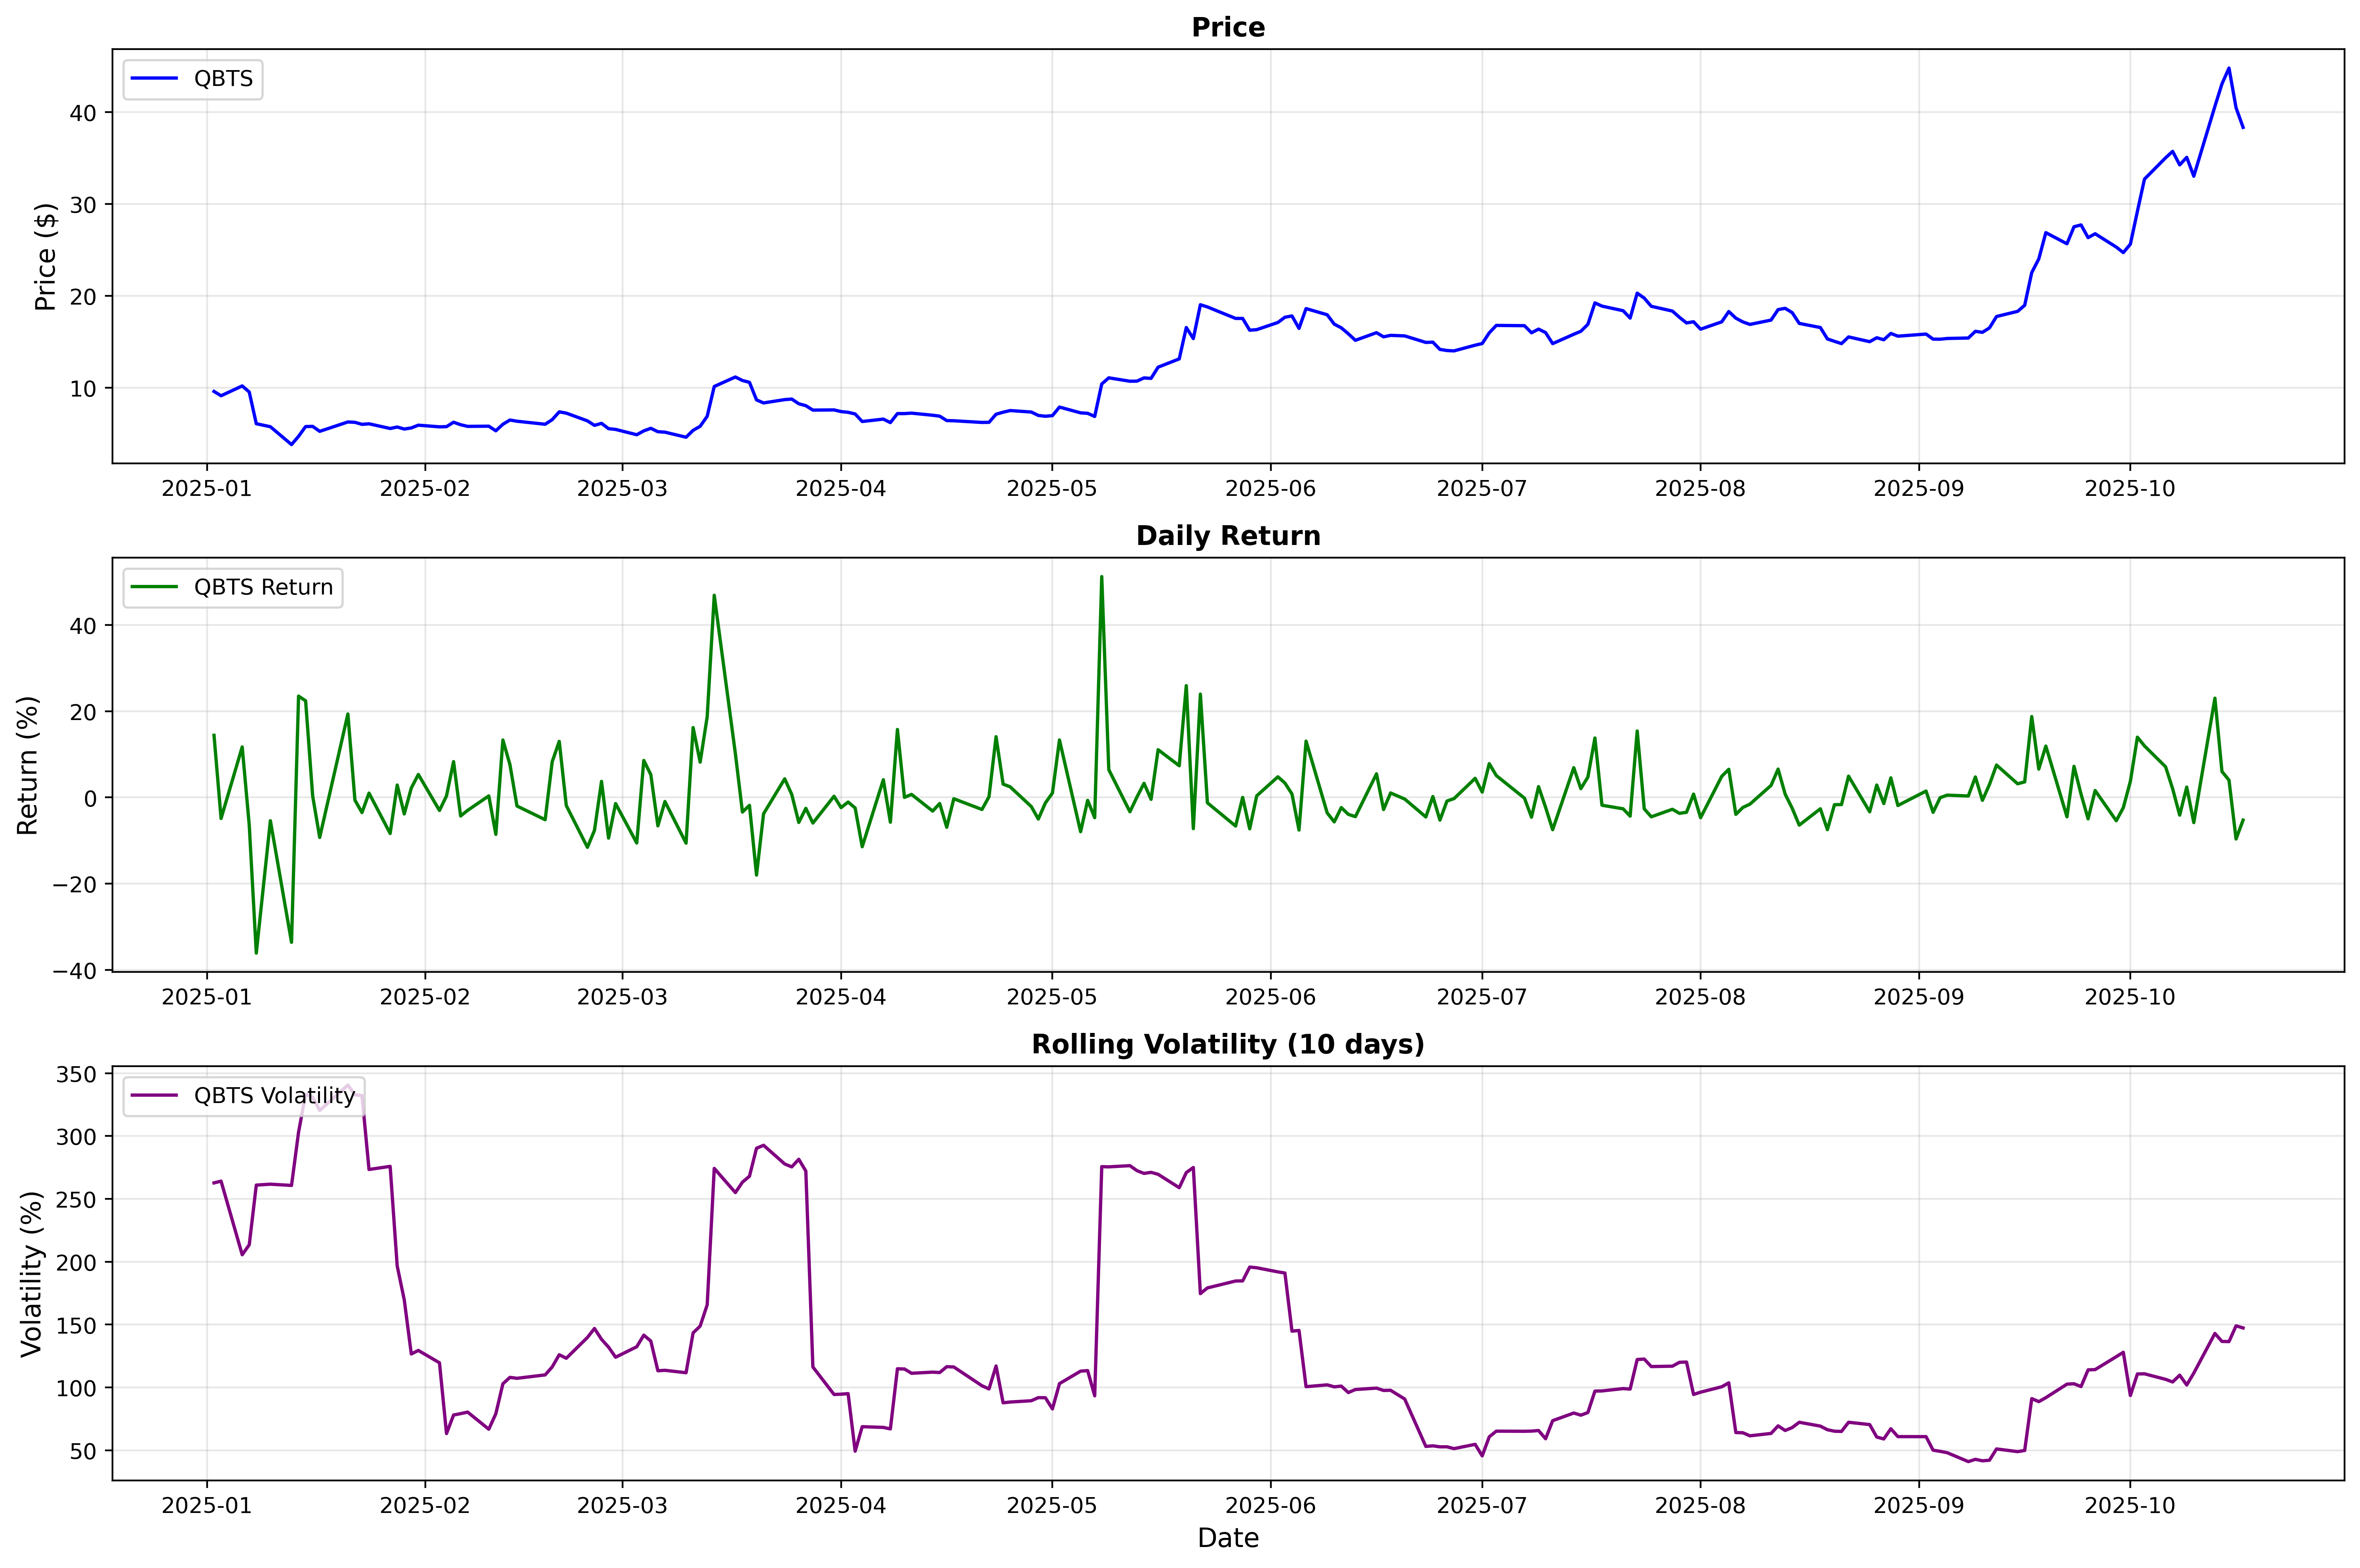


=== QBTS 통계 정보 ===
평균 일일 수익률: 1.1931%
수익률 표준편차: 9.4957%
평균 변동성: 132.1341%
최대 변동성: 340.4964%
최소 변동성: 41.0110%
샤프 비율: 0.9030


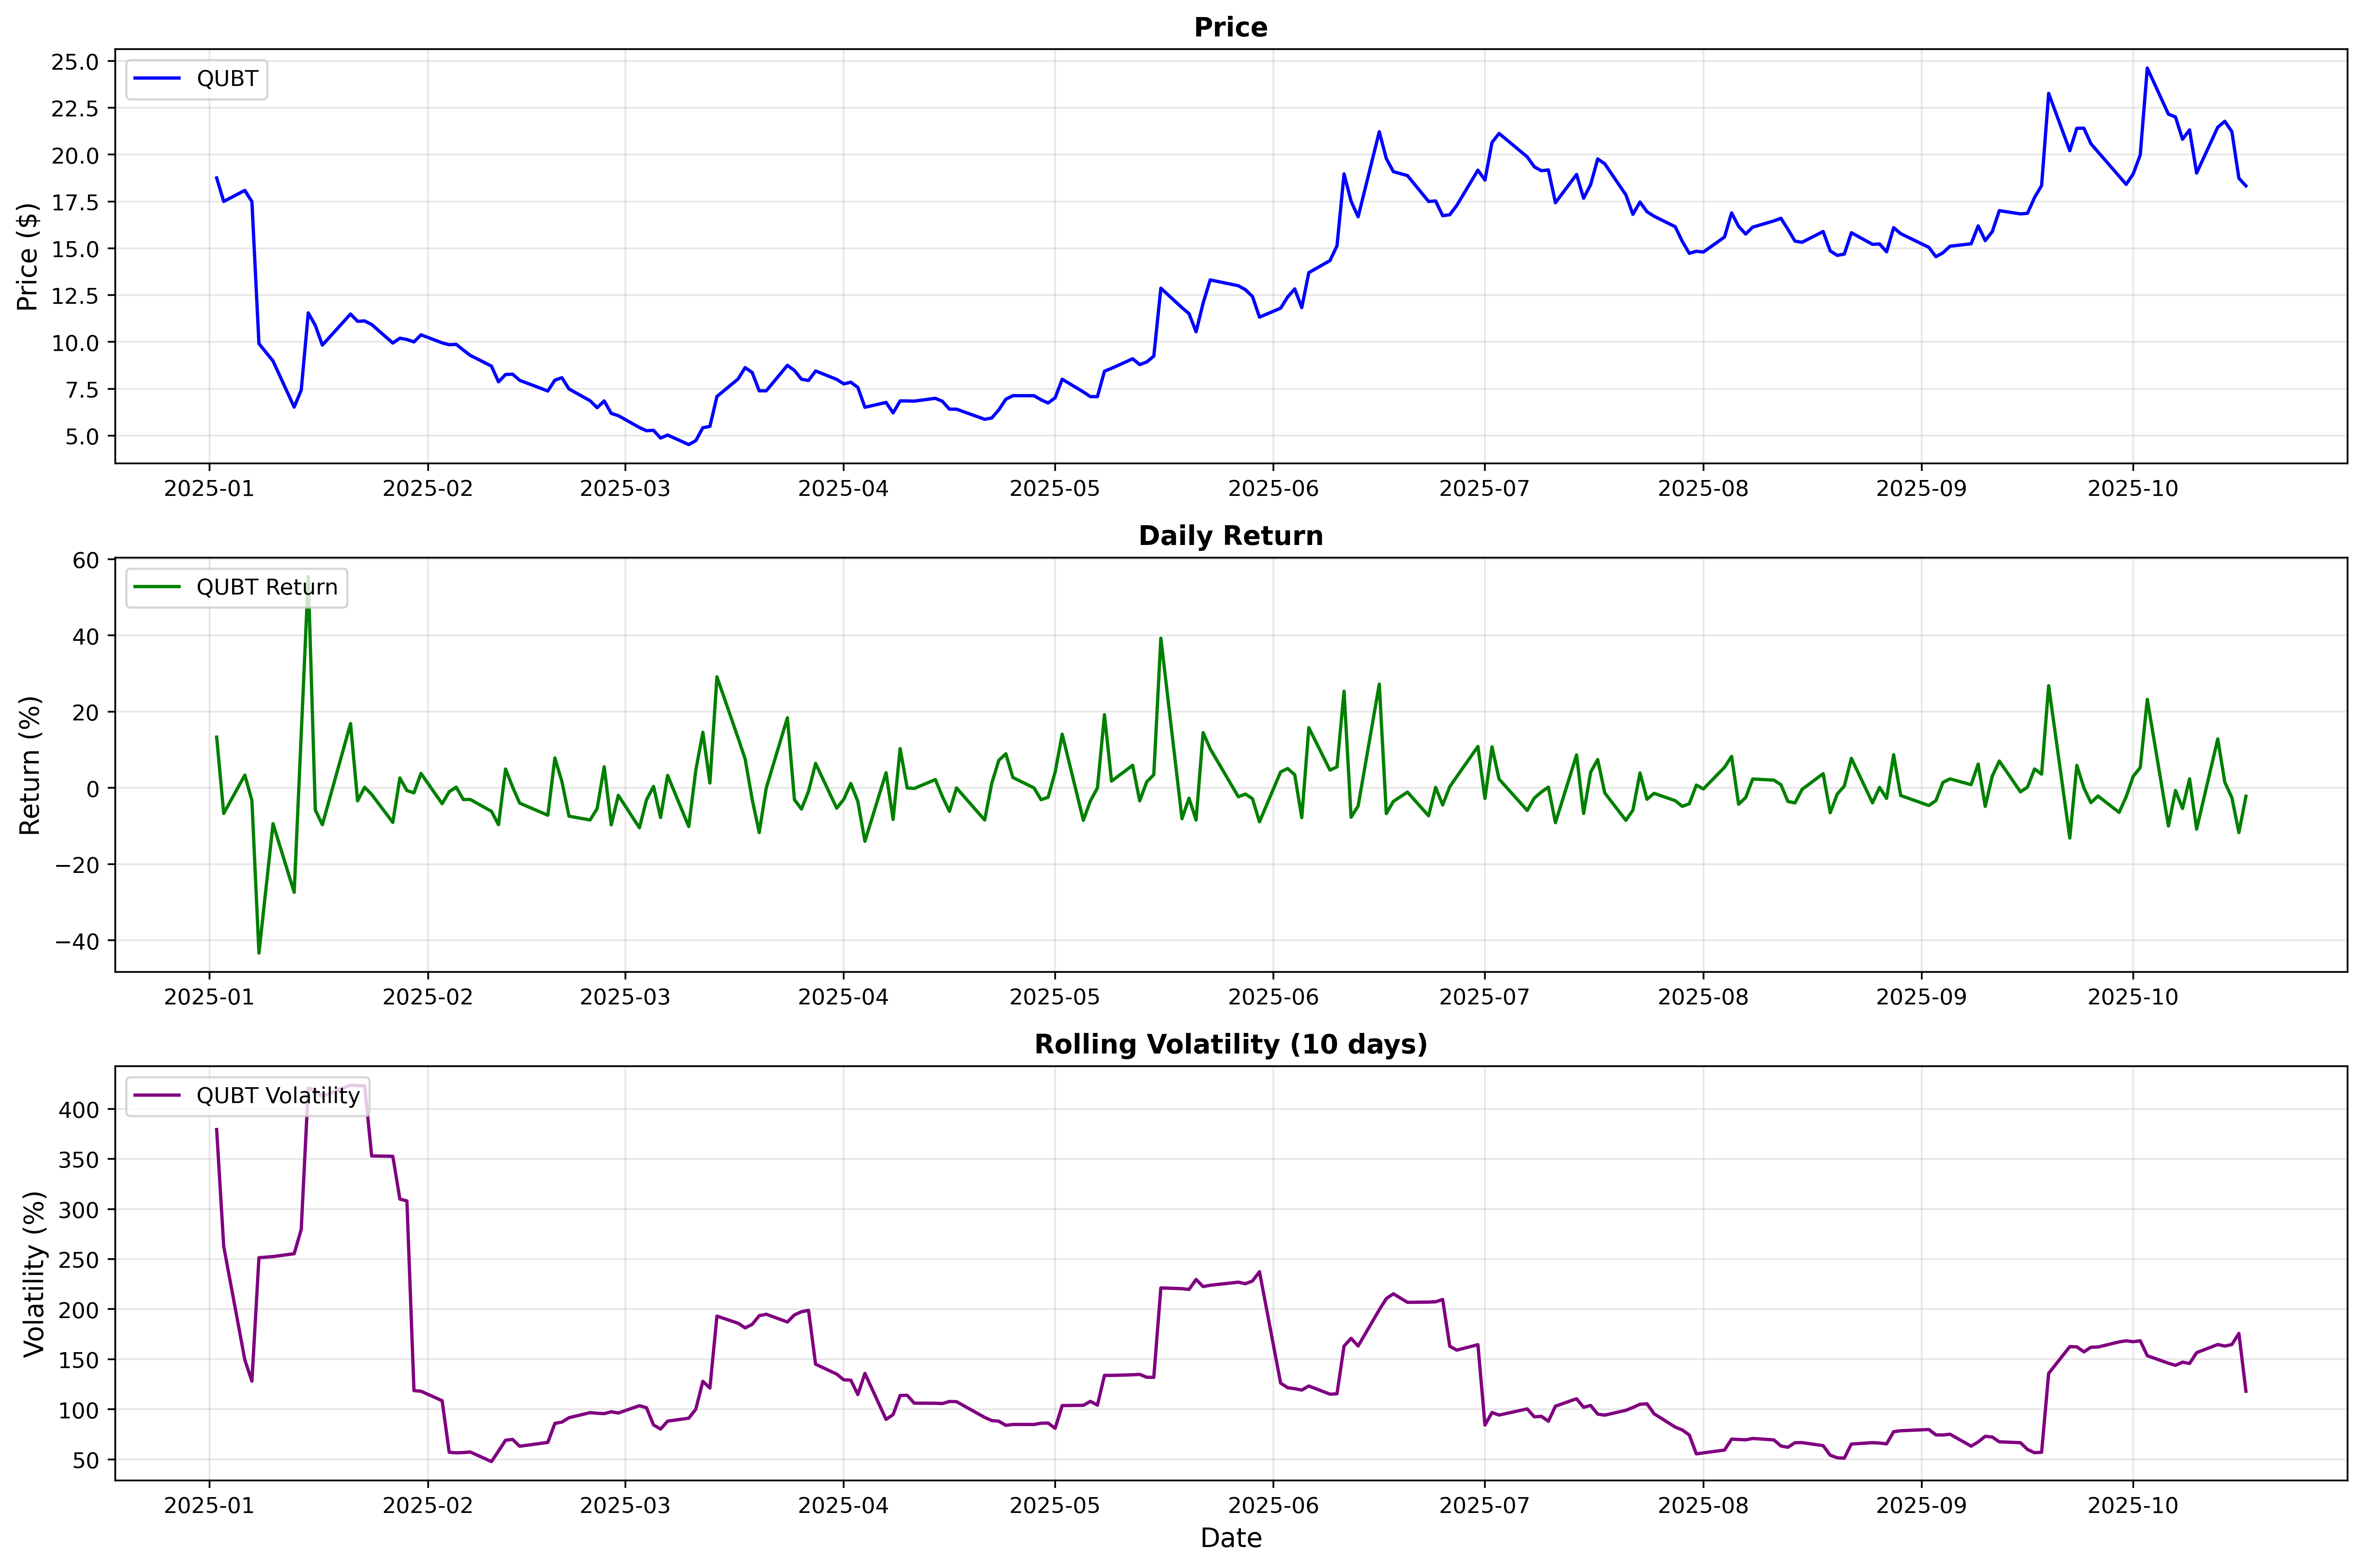


=== QUBT 통계 정보 ===
평균 일일 수익률: 0.4996%
수익률 표준편차: 9.6781%
평균 변동성: 136.5954%
최대 변동성: 423.7239%
최소 변동성: 47.8010%
샤프 비율: 0.3657


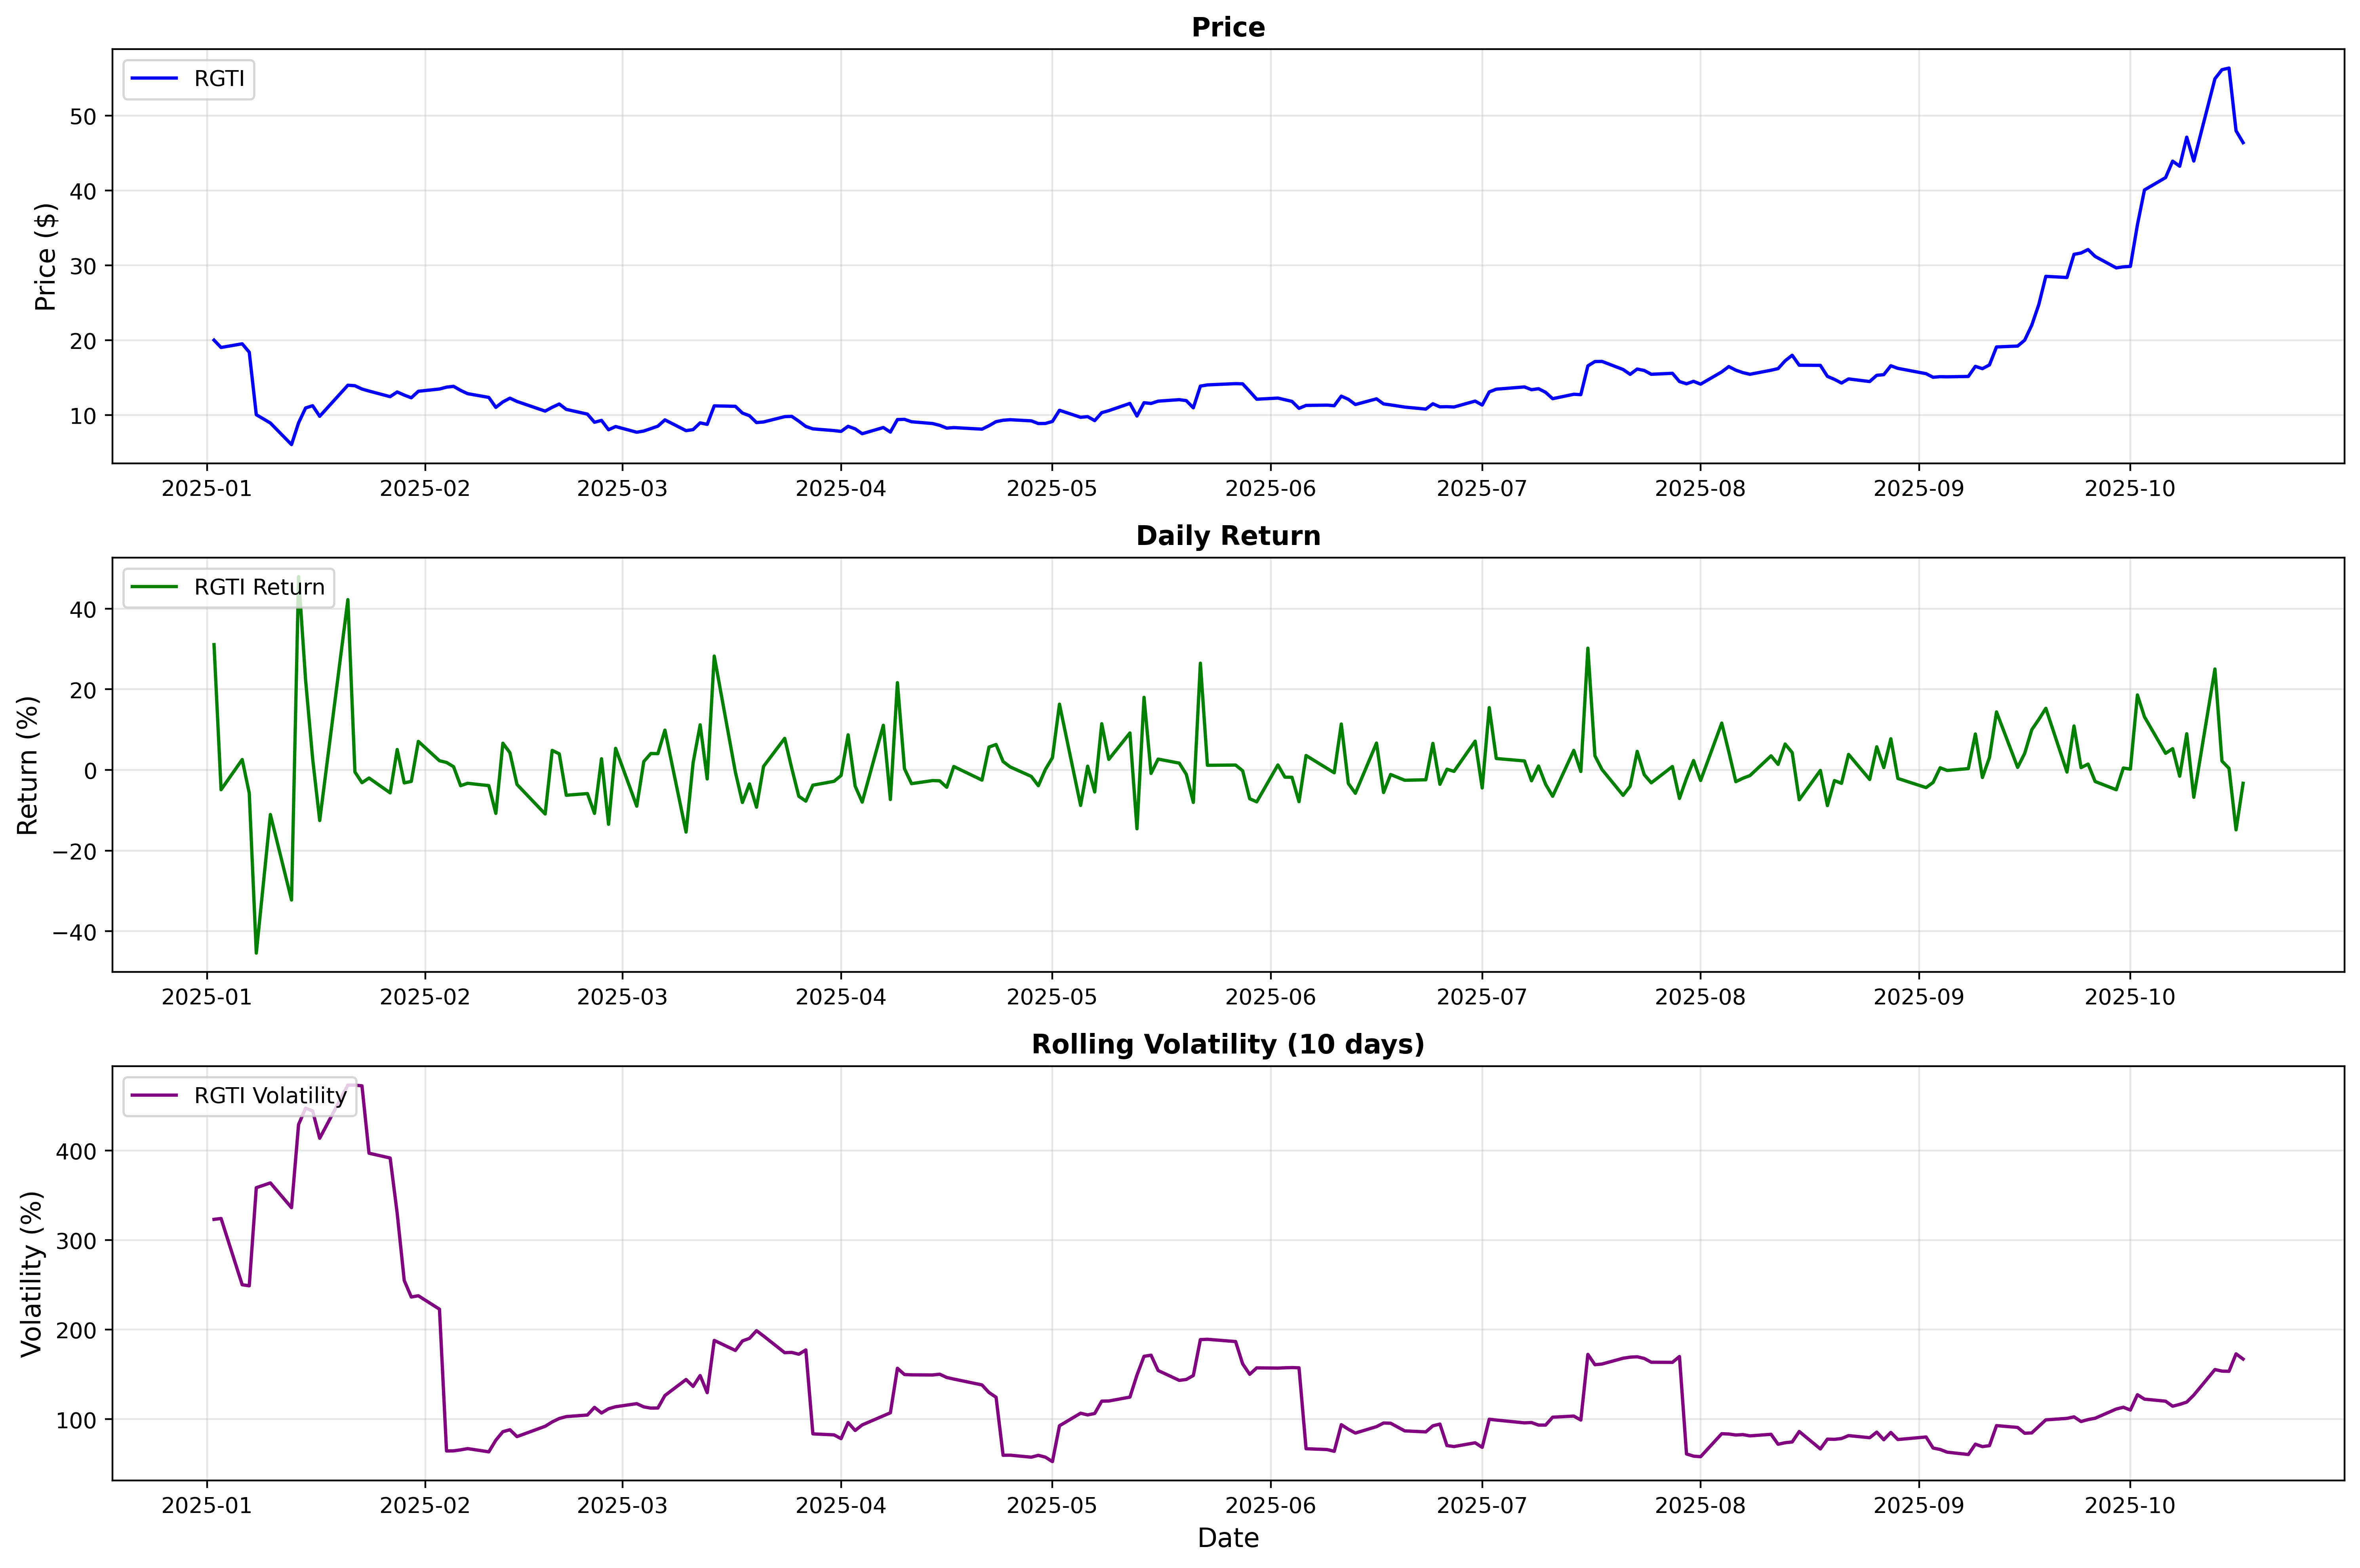


=== RGTI 통계 정보 ===
평균 일일 수익률: 1.0389%
수익률 표준편차: 9.8956%
평균 변동성: 137.3989%
최대 변동성: 473.0305%
최소 변동성: 52.7381%
샤프 비율: 0.7561


In [48]:
# plot_comn_improved(data['Close']['NVDA'], '2019-01-01')
plot_comn_improved(data['Close']['IBM'], '2025-01-01')
plot_comn_improved(data['Close']['IONQ'], '2025-01-01')
plot_comn_improved(data['Close']['QBTS'], '2025-01-01')
plot_comn_improved(data['Close']['QUBT'], '2025-01-01')
plot_comn_improved(data['Close']['RGTI'], '2025-01-01')
